In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
from torch.utils.data import ConcatDataset
import sys
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold


sys.path.append('../')
from models import VAE, SameTPred
from utils import BrainGraphDataset, project_root
import json
import copy

torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

lr = 0.001
batch_size = 32

# define the optimizer and the loss function

criterion = nn.L1Loss(reduction='sum')

root = project_root()

dataroot = 'fc_matrices/psilo_ica_100_before'
annotations = 'annotations-before.csv'
dataset = BrainGraphDataset(img_dir=os.path.join(root, dataroot),
                            annotations_file=os.path.join(root, annotations),
                            transform=None, extra_data=None, setting='upper_triangular')

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Create empty lists to store train and validation loaders
train_loaders = []
val_loaders = []

torch.manual_seed(0)
for train_index, val_index in kf.split(dataset):
    # Split dataset into train and validation sets for the current fold
    train_set = torch.utils.data.Subset(dataset, train_index)
    val_set = torch.utils.data.Subset(dataset, val_index)

    # Define the dataloaders for the current fold
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    # Append the loaders to the respective lists
    train_loaders.append(train_loader)
    val_loaders.append(val_loader)

num_epochs = 200

# Dictionary to store training and validation curves
curves = {}

best_set = [None] * 5

input_dim = 4950
for dropout in [0]:
    for t, train_loader in enumerate(train_loaders):
        val_loader = val_loaders[t]
    
        vae = VAE(4950, [128] * 2, 64).to(device)  # move model to device
        vae.load_state_dict(torch.load(os.path.join(root, 'vae_weights/vae_dropout_psilo_ica_before_0.pt'), map_location=device))
        vae = vae.to(device)

        model = SameTPred(64, 256, dropout=dropout)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        # Convert the MLP to the device
        model.to(device)

        best_val_loss = float('inf')
        best_state = None

        # Lists to store training and validation losses
        train_losses = []
        val_losses = []

        best_pass = None
        # train the MLP on the new dataset
        for epoch in range(num_epochs):
            running_loss = 0.0

            for i, data in enumerate(train_loader, 0):
                # get the inputs
                graphs, labels = data

                graphs = graphs.to(device)
                labels = labels.to(device).float()

                _, _, _, z = vae(graphs.view(-1, input_dim))

                # zero the parameter gradients
                optimizer.zero_grad()

                preds = model(z)

                # calculate the loss and backpropagate
                loss = model.loss(preds, labels.view(preds.shape))
                loss.backward()
                optimizer.step()

                # print statistics
                running_loss += loss.item()

            # Validation check
            val_loss = 0.0
            val_label = []
            val_output = []
            with torch.no_grad():
                for data in val_loader:
                    graphs, labels = data

                    graphs = graphs.to(device)
                    labels = labels.to(device).float()

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    _, _, _, z = vae(graphs.view(-1, input_dim))

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    preds = model(z)

                    val_label.extend(labels.flatten().tolist())
                    val_output.extend(preds.flatten().tolist())

                    val_loss += criterion(preds, labels.view(preds.shape)).item()
            val_loss /= len(val_set)

            # Save the best model so far
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_state = (copy.deepcopy(model.state_dict()), copy.deepcopy(vae.state_dict()))
                best_pass = (val_label, val_output)

            # Print statistics and perform testing every 5 epochs
            print('[%d] loss: %.3f, val_loss: %.3f' % (epoch + 1, running_loss / (len(train_set)), val_loss))

            train_losses.append(running_loss / (len(train_set)))
            val_losses.append(val_loss)
        best_set[t] = best_pass
print('Finished Training')

[1] loss: 25.800, val_loss: 29.074
[2] loss: 24.847, val_loss: 27.641
[3] loss: 23.634, val_loss: 25.453
[4] loss: 21.749, val_loss: 22.125
[5] loss: 18.866, val_loss: 17.189
[6] loss: 14.732, val_loss: 10.086
[7] loss: 9.260, val_loss: 6.398
[8] loss: 5.823, val_loss: 13.247
[9] loss: 10.956, val_loss: 12.019
[10] loss: 9.761, val_loss: 8.059
[11] loss: 6.025, val_loss: 6.353
[12] loss: 5.931, val_loss: 7.435
[13] loss: 6.927, val_loss: 8.068
[14] loss: 7.428, val_loss: 7.723
[15] loss: 7.102, val_loss: 6.643
[16] loss: 6.321, val_loss: 6.239
[17] loss: 5.638, val_loss: 7.056
[18] loss: 5.559, val_loss: 8.048
[19] loss: 5.981, val_loss: 7.833
[20] loss: 5.903, val_loss: 7.051
[21] loss: 5.501, val_loss: 6.421
[22] loss: 5.440, val_loss: 6.406
[23] loss: 5.518, val_loss: 6.514
[24] loss: 5.535, val_loss: 6.457
[25] loss: 5.461, val_loss: 6.450
[26] loss: 5.296, val_loss: 6.833
[27] loss: 5.185, val_loss: 7.220
[28] loss: 5.225, val_loss: 7.195
[29] loss: 5.179, val_loss: 6.740
[30] los

-0.41517727343572886
PearsonRResult(statistic=0.04067191139017011, pvalue=0.798155259911576)
5.106329191298712


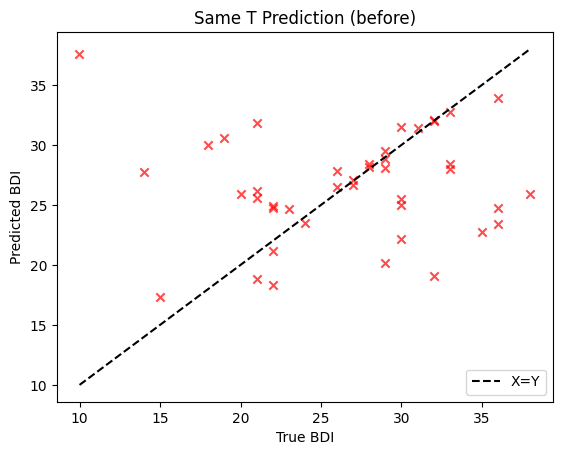

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score, mean_absolute_error

true = []
pred = []

for fold in best_set:
    true.extend(fold[0])
    pred.extend(fold[1])

print(r2_score(true, pred))
print(pearsonr(true, pred))
print(mean_absolute_error(true, pred))

# Generate jittered data
jitter = 0.01  # Adjust the jittering amount as needed
true_jittered = np.array(true) + np.random.uniform(low=-jitter, high=jitter, size=len(true))
pred_jittered = np.array(pred) + np.random.uniform(low=-jitter, high=jitter, size=len(pred))

plt.scatter(true_jittered, pred_jittered, alpha=0.7, color='red', marker='x')

min_val = min(min(true), min(pred))
max_val = max(max(true), max(pred))
plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='X=Y')

plt.xlabel('True BDI')
plt.ylabel('Predicted BDI')
plt.title('Same T Prediction (before)')
plt.legend()
plt.savefig('same_t_pred_before.png', bbox_inches='tight')
plt.show()

# Specify the filename for the CSV file
filename = 'same-t-pred-before-vae.csv'

# Create a list of rows with headers
rows = [['true_post_bdi', 'predicted_post_bdi']]
for true, pred in zip(true, pred):
    rows.append([true, pred])

import csv

# Write the rows to the CSV file
with open(filename, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(rows)
